<h2 style="color:darkred;font-size:30px">Projet 4 : Segmentez des clients d'un site e-commerce</h2>

<img src="images\olist.png" style="width: 250px;"/>

<h2 style="color:darkred;font-size:30px">Notebook 2 : Modélisation (K-Means 1)</h2>
<h2 style="color:darkred;font-size:20px">Dataset avec les catégories des produits</h2>

---
---
---

<h2 style="color:darkred;font-size:20px">Sommaire</h2>
    
    Notebook 1 ____ Nettoyage ________________________________________________________________
    
    Notebook 2 ____ Modélisation (Machine Learning) __________________________________________
    6. Preprocessing
        6.1 Standardisation
        6.2 Réduction dimensionnelle (ACP)
    7. K-Means (avec les catégories des produits)
        7.1 Evaluation et optimisation
        7.2 Visualisation et interprétation des clusters

In [181]:
# les libraries nécessaires :
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# la librarie des fonctions crée pour le projet olist
from olist_functions import *

# preprocessing
from sklearn import preprocessing

# K-Means de Sklearn
from sklearn.cluster import KMeans

# Pour la réduction dimensionelle
from sklearn import decomposition

# yellowbrick pour elbow methode
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# initiate notebook for offline plot
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objects as go
# Reference : https://plotly.com/python/pie-charts/

init_notebook_mode(connected=True)  # initiate notebook for offline plot

In [182]:
# pour voir toutes les colonnes
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 100)

# style de titres
font = {'family': 'Arial',
        'color':  'darkred',
        'weight': 'bold',
        'size': 30,
        }

In [183]:
# lire le fichier csv data_clean
olist_data = pd.read_csv('data/olist_data_clean.csv',
                         index_col='customer_unique_id')
print('Le jeu des données olist_data compte {} colonnes et {} lignes.'.format(olist_data.shape[1],
                                                                              olist_data.shape[0]))

Le jeu des données olist_data compte 28 colonnes et 96093 lignes.


In [184]:
# Remise en forme les datatypes

liste = list(olist_data.columns)
liste.remove('last_purchase')
liste
for column in liste:
    olist_data[column] = olist_data[column].astype('Int64')

olist_data['last_purchase'] = olist_data['last_purchase'].astype(
    'datetime64[ns]')

In [185]:
olist_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96093 entries, 861eff4711a542e4b93843c6dd7febb0 to 84732c5050c01db9b23e19ba39899398
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   anciennete_du_client    96093 non-null  Int64         
 1   last_purchase           96093 non-null  datetime64[ns]
 2   date_derniere_commande  96093 non-null  Int64         
 3   nb_commandes            96093 non-null  Int64         
 4   nb_payements            96093 non-null  Int64         
 5   nb_produit              96093 non-null  Int64         
 6   depense_total           96093 non-null  Int64         
 7   review_score_min        96093 non-null  Int64         
 8   montant_commande_max    96093 non-null  Int64         
 9   montant_produit_max     95419 non-null  Int64         
 10  frais_de_port_moy       95419 non-null  Int64         
 11  delai_livraison_max     93355 non-null  Int64        

In [186]:
# Enlevons "last_purchase" de data puisque nous allons l'utiliser pour la maintenance. 
# Nous le gardons dans olist_data

data = olist_data.drop(['last_purchase'], axis=1)

In [187]:
# Enlevons toutes les valeurs manquantes

data.dropna(how='any', inplace=True)

In [188]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92889 entries, 861eff4711a542e4b93843c6dd7febb0 to 84732c5050c01db9b23e19ba39899398
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   anciennete_du_client    92889 non-null  Int64
 1   date_derniere_commande  92889 non-null  Int64
 2   nb_commandes            92889 non-null  Int64
 3   nb_payements            92889 non-null  Int64
 4   nb_produit              92889 non-null  Int64
 5   depense_total           92889 non-null  Int64
 6   review_score_min        92889 non-null  Int64
 7   montant_commande_max    92889 non-null  Int64
 8   montant_produit_max     92889 non-null  Int64
 9   frais_de_port_moy       92889 non-null  Int64
 10  delai_livraison_max     92889 non-null  Int64
 11  delai_estime            92889 non-null  Int64
 12  volume_produit_max      92889 non-null  Int64
 13  densite_produit_max     92889 non-null  Int64
 14  distance         

# 6. Preprocessing

## 6.1 Standardisation

In [189]:
X = data.values

In [190]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

## 6.2 Réduction dimensionnelle (ACP)

_Il s'agira de trouver $m$ variables, avec $m<p$, que nous allons choisir d'utiliser pour construire une nouvelle matrice $X̃$, de dimension $n×m$ pour représenter nos données._

_Pour rappel, l’objectif d’une analyse par composantes principales est de réduire la dimension du jeu de donnée en conservant un maximum d’information, c’est à dire de variance. En d' autres termes, nous voulons réduire la dimension des données, tout en gardant autant que possible les informations qui permettent de distinguer les observations._

### Scree Plot

_Ce graphique présente la proportion de variance expliquée par la k-ième composante principale, ou par les k premières composantes principales, en fonction de k._

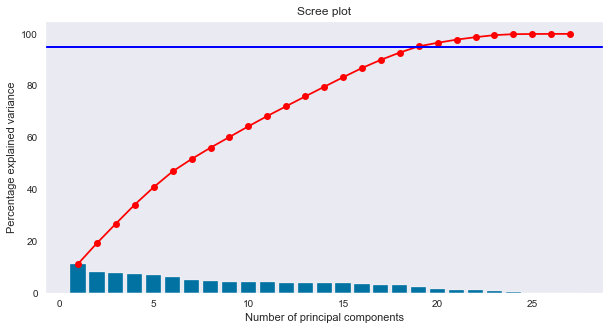

In [191]:
num_components = 27
pca_all = decomposition.PCA(n_components=num_components, random_state=42)
pca_all.fit(X_scaled)

display_scree_plot(pca_all) 

# 19

In [192]:
print(pca_all.explained_variance_ratio_.cumsum().round(2))

[0.11 0.19 0.27 0.34 0.41 0.47 0.52 0.56 0.6  0.64 0.68 0.72 0.76 0.8
 0.83 0.87 0.9  0.93 0.95 0.97 0.98 0.99 1.   1.   1.   1.   1.  ]


In [193]:
# nous sélectionnons le nombre de composants principaux que nous retournerons
num_components = 19

pca = decomposition.PCA(n_components=num_components, random_state=42)
pca.fit(X_scaled)

# Transform the scaled data to the new PCA space
X_reduced = pca.transform(X_scaled)

### Cercle des Correlations

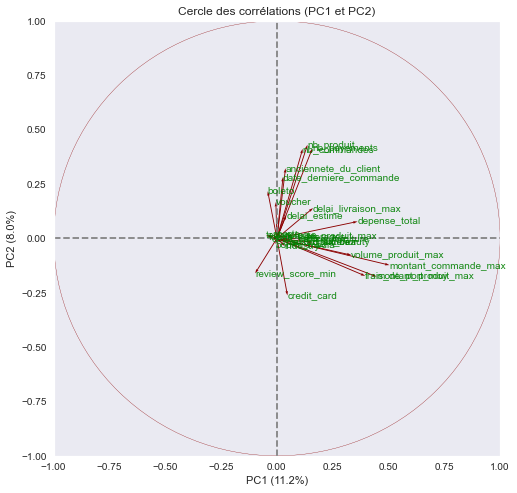

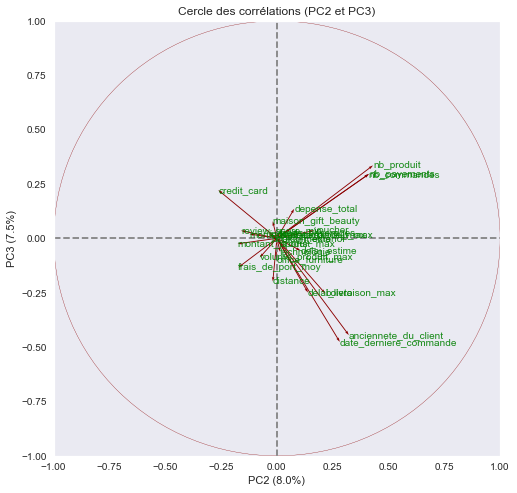

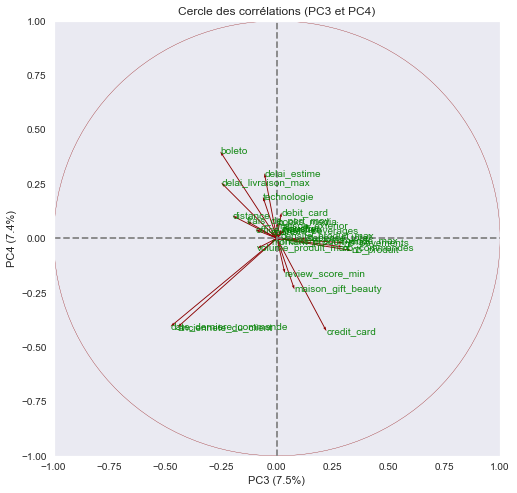

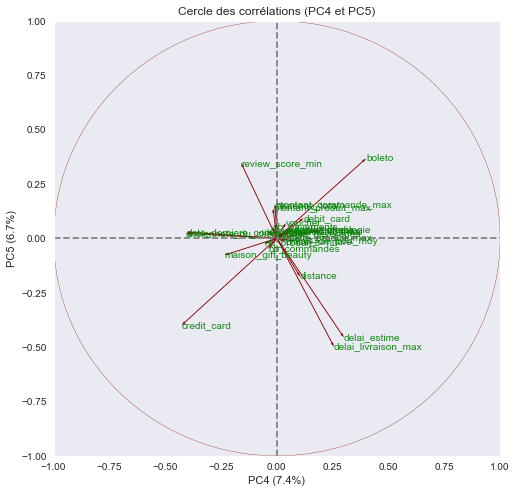

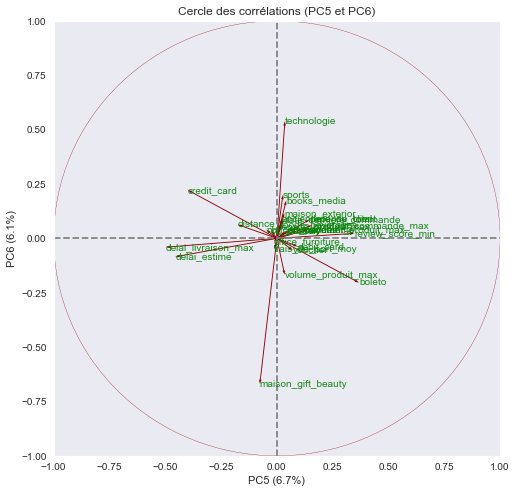

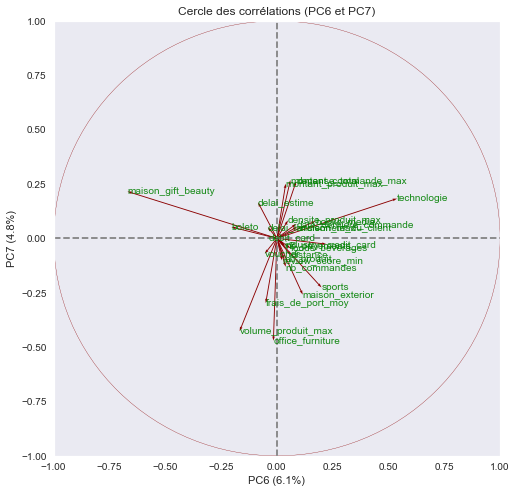

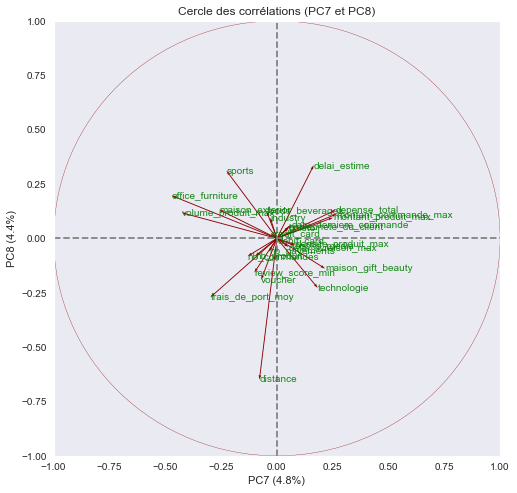

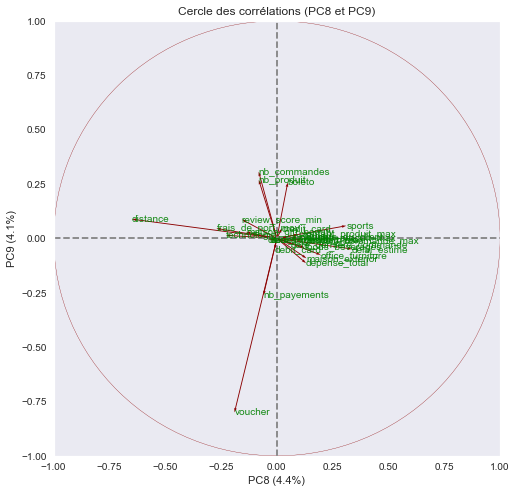

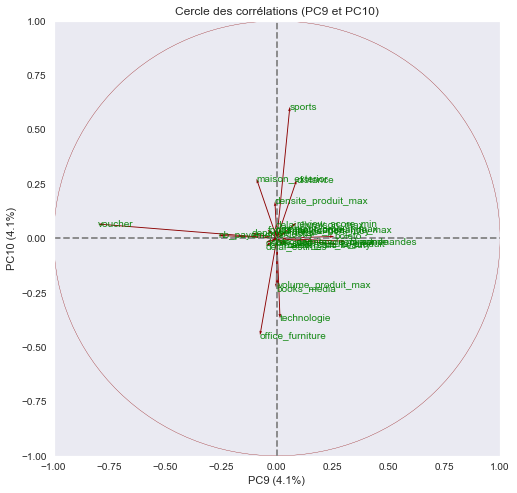

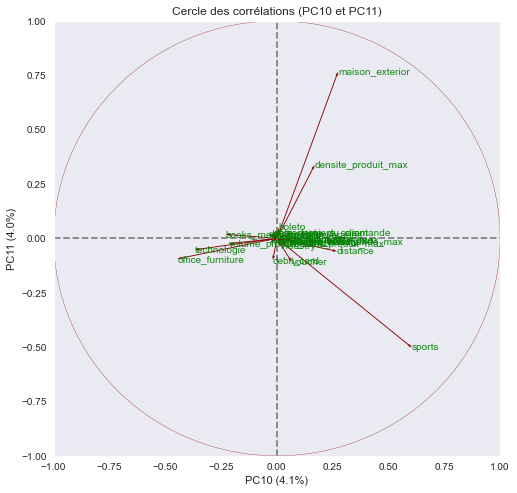

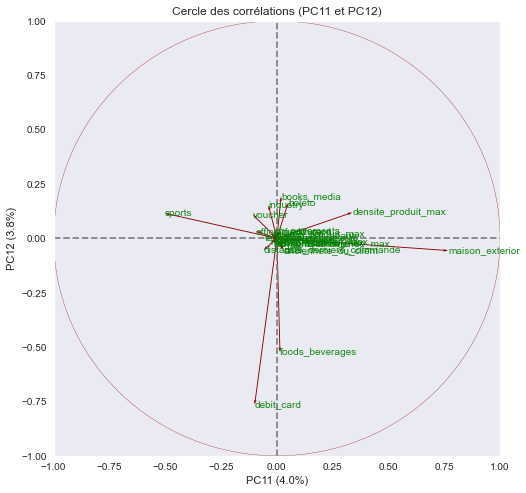

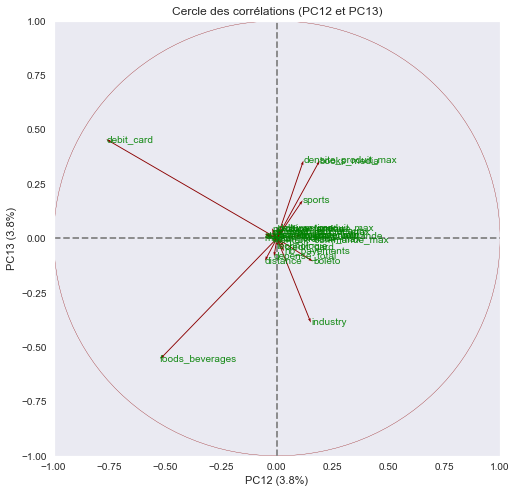

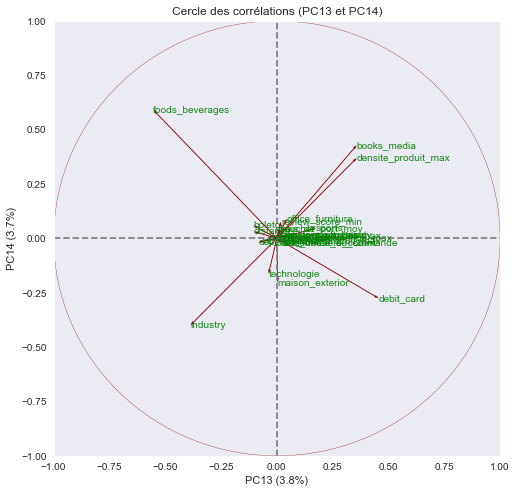

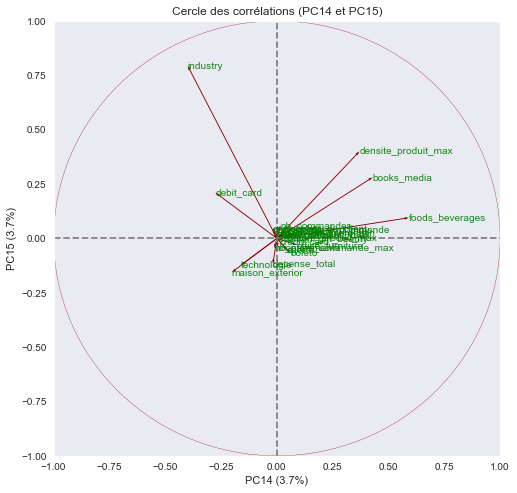

In [270]:
pcs = pca.components_

for i in range(0, 14):
    display_circles(pcs, num_components, pca, [
                    (i, i+1)], labels=np.array(data.columns))

# 7. k-Means

## 7.1 Evaluation et optimisation

### La méthode Elbow

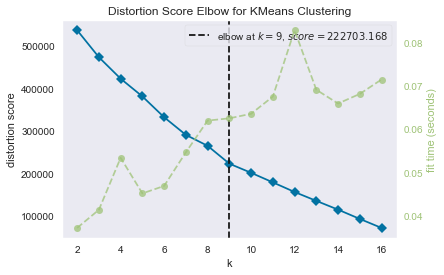

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [194]:
# Generate synthetic dataset with 8 random clusters
X, y = make_blobs(n_samples=1000, n_features=19, centers=19, random_state=42)

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,17))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# reference : https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
# https://www.kaggle.com/kautumn06/yellowbrick-clustering-evaluation-examples
# si erreur : https://github.com/DistrictDataLabs/yellowbrick/issues/1137

### Silhouette score

In [195]:
%pylab inline

from sklearn import cluster, metrics

Populating the interactive namespace from numpy and matplotlib


/Users/fyasar/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['radians', 'cos', 'sqrt', 'sin']
`%matplotlib` prevents importing * from pylab and numpy



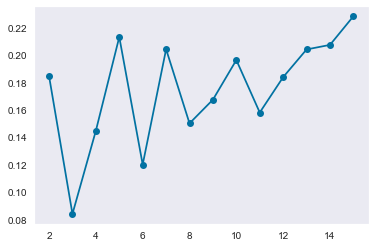

In [196]:
silhouettes = []

for num_clusters in range(2, 16):
    cls = cluster.KMeans(
        n_clusters=num_clusters,
        n_init=num_clusters,
        init='random', # essayé aussi 'k-means++'
        random_state=42,
    )
    cls.fit(X_reduced)
    silh = metrics.silhouette_score(X_reduced, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(2, 16), silhouettes, marker='o')

In [197]:
sns.color_palette("Set2")
sns.set_style("dark")

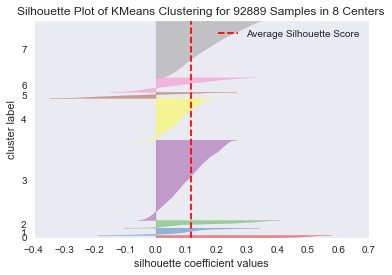

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92889 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [273]:
# Instantiate the clustering model and visualizer 
visualizer = SilhouetteVisualizer(KMeans(init='random', n_clusters=8, n_init=10))

visualizer.fit(X_scaled)    # Fit the data to the visualizer
visualizer.show()    # Draw/show/poof the data

#https://towardsdatascience.com/performance-metrics-in-machine-learning-part-3-clustering-d69550662dc6

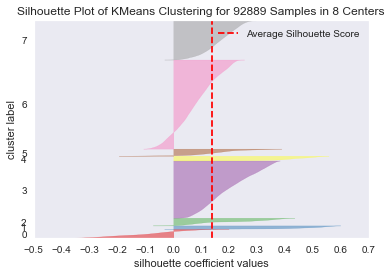

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92889 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [274]:
visualizer = SilhouetteVisualizer(KMeans(init='random', n_clusters=8, n_init=6))

visualizer.fit(X_reduced)    # Fit the data to the visualizer
visualizer.show()

## 7.2 Exécution de l'algorithme pour les meilleurs hyperparamètres

In [221]:
# Create a k-means clustering model
kmeans = KMeans(init='random', n_clusters=8, n_init=20, random_state=42)

# We will ask for 8 clusters (the  n_clusters  parameter) and
# ask for clustering to be performed 10 times,
# starting with different centroids (this is the  n_init  parameter)

# Fit the data to the model
kmeans.fit(X_reduced)

# Determine which clusters each data point belongs to:
clusters =  kmeans.predict(X_reduced)

In [222]:
# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(X_scaled, index=data.index, columns=data.columns)
X_clustered["cluster"] = clusters

# 8. Visualisation et interprétation des clusters

### Individuals Factor Map

### Box plots

In [223]:
X_clustered.head()

,anciennete_du_client,date_derniere_commande,nb_commandes,nb_payements,nb_produit,depense_total,review_score_min,montant_commande_max,montant_produit_max,frais_de_port_moy,delai_livraison_max,delai_estime,volume_produit_max,densite_produit_max,distance,boleto,credit_card,debit_card,voucher,maison_gift_beauty,technologie,maison_exterior,books_media,foods_beverages,sports,industry,office_furniture,cluster
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,1.502474,1.526164,-0.164174,-0.283584,-0.219007,-0.102646,-0.095863,-0.060828,-0.014709,0.116138,-0.435087,0.071344,3.859939,-0.159057,-0.426145,-0.499832,0.575253,-0.12604,-0.189751,-1.146378,-0.496468,-0.249974,-0.152568,-0.112699,-0.289739,-0.077107,8.700826,3
290c77bc529b7ac935b93aa66c333dc3,-0.077290,-0.059194,-0.164174,-0.283584,-0.219007,0.187225,0.669008,0.794067,0.835774,1.642535,0.395813,0.365777,1.594794,-0.007961,-0.316690,-0.499832,0.575253,-0.12604,-0.189751,0.872312,-0.496468,-0.249974,-0.152568,-0.112699,-0.289739,-0.077107,-0.114932,2
060e732b5b29e8181a18229c7b0b2b5e,-0.899811,-0.884629,-0.164174,-0.283584,-0.219007,-0.085685,0.669008,-0.010808,0.063079,-0.138262,1.434438,1.249077,1.281511,-0.021697,-0.963317,-0.499832,0.575253,-0.12604,-0.189751,-1.146378,-0.496468,-0.249974,-0.152568,-0.112699,-0.289739,-0.077107,8.700826,3
259dac757896d24d7702b9acbbff3f3c,-0.462439,-0.445707,-0.164174,-0.283584,-0.219007,-0.062557,0.669008,0.057402,0.114938,0.179738,0.188088,-0.124944,2.714720,-0.062905,-0.981840,-0.499832,0.575253,-0.12604,-0.189751,-1.146378,-0.496468,-0.249974,-0.152568,-0.112699,-0.289739,-0.077107,8.700826,3
345ecd01c38d18a9036ed96c73b8d066,-1.363295,-1.349755,-0.164174,-0.283584,-0.219007,0.059250,0.669008,0.416640,0.529808,0.116138,-0.123499,0.562066,0.339682,0.033247,-0.643371,-0.499832,0.575253,-0.12604,-0.189751,0.872312,-0.496468,-0.249974,-0.152568,-0.112699,-0.289739,-0.077107,-0.114932,2


### Heat map

In [224]:
x = X_clustered.groupby('cluster').mean()

In [225]:
std_scale = preprocessing.StandardScaler().fit(x)
x_scaled = std_scale.transform(x)

<AxesSubplot:>

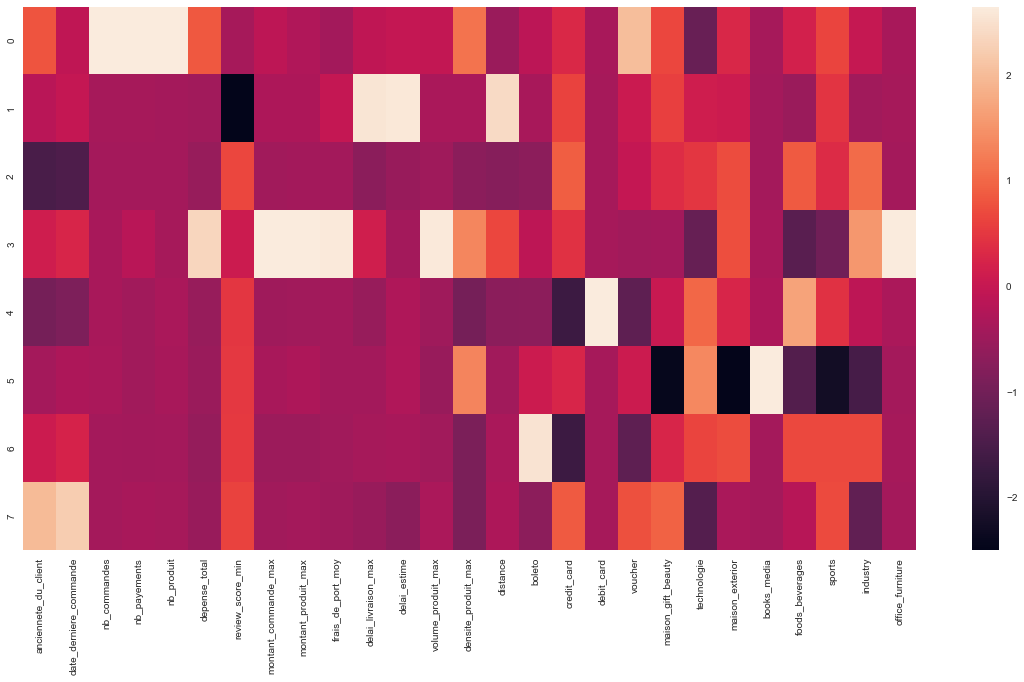

In [226]:
fig = plt.figure(figsize=(20,10))
sns.heatmap(pd.DataFrame(x_scaled, columns=x.columns))

In [252]:
x_clustered = pd.DataFrame(x_scaled, columns=x.columns)
x_clustered

,anciennete_du_client,date_derniere_commande,nb_commandes,nb_payements,nb_produit,depense_total,review_score_min,montant_commande_max,montant_produit_max,frais_de_port_moy,delai_livraison_max,delai_estime,volume_produit_max,densite_produit_max,distance,boleto,credit_card,debit_card,voucher,maison_gift_beauty,technologie,maison_exterior,books_media,foods_beverages,sports,industry,office_furniture
0,0.802708,-0.088328,2.645341,2.636370,2.645257,0.852895,-0.374665,-0.092244,-0.257447,-0.414112,-0.087471,-0.011122,-0.043394,1.118228,-0.528330,-0.123258,0.303864,-0.363076,2.029454,0.654810,-1.124590,0.288859,-0.389544,0.172402,0.647796,0.002466,-0.363251
1,-0.151507,-0.023456,-0.388017,-0.384893,-0.394777,-0.449457,-2.502770,-0.308223,-0.295717,-0.019873,2.557231,2.596783,-0.343602,-0.347846,2.406298,-0.352161,0.623270,-0.381454,0.063511,0.589506,0.129016,0.081507,-0.395695,-0.528011,0.463928,-0.435369,-0.384029
2,-1.504442,-1.438240,-0.396513,-0.404249,-0.393723,-0.553398,0.657843,-0.449955,-0.426449,-0.424319,-0.710841,-0.536161,-0.459064,-0.708945,-0.771398,-0.687725,0.906163,-0.381805,-0.021933,0.356221,0.480237,0.719128,-0.396177,0.864131,0.333417,1.041552,-0.395674
3,0.126795,0.264781,-0.359982,-0.166145,-0.372515,2.355055,0.080108,2.625630,2.637095,2.621104,0.142135,-0.427040,2.619096,1.347178,0.669038,-0.090799,0.429460,-0.373714,-0.441635,-0.413988,-1.153863,0.736765,-0.363196,-1.310179,-1.027796,1.548909,2.644995
4,-0.956432,-0.870362,-0.360752,-0.438053,-0.337857,-0.570975,0.475895,-0.470625,-0.447793,-0.425226,-0.562413,-0.277406,-0.457898,-0.970103,-0.704003,-0.685163,-1.688684,2.645700,-1.241879,0.047592,1.005223,0.270518,-0.307693,1.681064,0.429297,-0.094102,-0.321128
5,-0.397662,-0.298776,-0.349426,-0.446416,-0.360028,-0.513674,0.510057,-0.358313,-0.298796,-0.430130,-0.411570,-0.267090,-0.544604,1.338388,-0.434855,0.090512,0.256353,-0.381935,0.082203,-2.442397,1.369183,-2.481093,2.644660,-1.383352,-2.244204,-1.549944,-0.396225
6,0.087364,0.228639,-0.394378,-0.429233,-0.397188,-0.575230,0.528599,-0.508563,-0.507820,-0.440954,-0.386093,-0.369468,-0.442377,-0.890402,-0.333994,2.535708,-1.690255,-0.381841,-1.240449,0.266552,0.653089,0.715177,-0.396177,0.677161,0.687326,0.687560,-0.388462
7,1.993177,2.225743,-0.396272,-0.367382,-0.389168,-0.545216,0.624933,-0.437708,-0.403072,-0.466491,-0.540977,-0.708495,-0.328158,-0.886498,-0.302757,-0.687113,0.859828,-0.381875,0.770730,0.941705,-1.358294,-0.330861,-0.396177,-0.173217,0.710234,-1.201073,-0.396225


### Radar plots

In [265]:
import plotly.graph_objects as go

fig = go.Figure()

for i in x_clustered.index:
    fig.add_trace(go.Scatterpolar(
        r=x_clustered[x_clustered.index==i].values.reshape(-1),
        theta=x_clustered.columns,
        fill='toself',
        name='Cluster ' + str(i)
))

fig.update_layout(
template="plotly_dark"
)

fig.show()

### Parallel Coordinates Plot

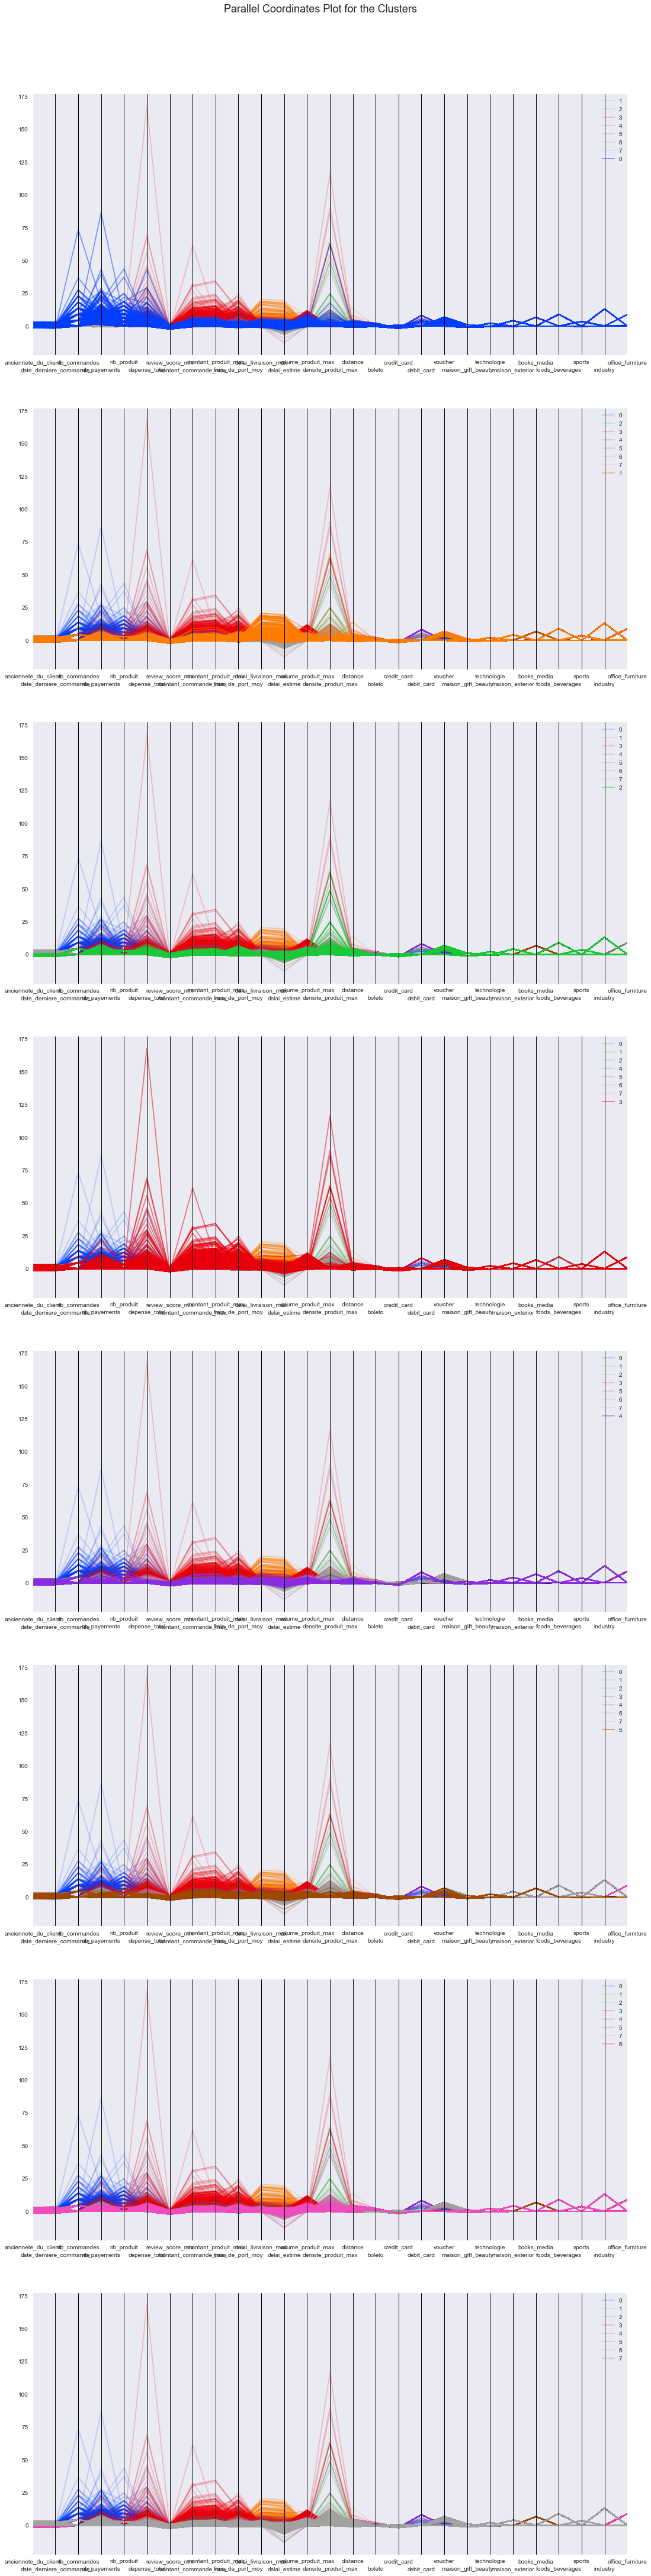

In [268]:
# Display parallel coordinates plots, one for each cluster
display_parallel_coordinates(X_clustered, 8)

In [ ]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=data.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 10)

# 9. Maintenance

In [312]:
# Enlevons toutes les valeurs manquantes

olist_data.dropna(how='any', inplace=True)
olist_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92889 entries, 861eff4711a542e4b93843c6dd7febb0 to 84732c5050c01db9b23e19ba39899398
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   anciennete_du_client    92889 non-null  Int64         
 1   last_purchase           92889 non-null  datetime64[ns]
 2   date_derniere_commande  92889 non-null  Int64         
 3   nb_commandes            92889 non-null  Int64         
 4   nb_payements            92889 non-null  Int64         
 5   nb_produit              92889 non-null  Int64         
 6   depense_total           92889 non-null  Int64         
 7   review_score_min        92889 non-null  Int64         
 8   montant_commande_max    92889 non-null  Int64         
 9   montant_produit_max     92889 non-null  Int64         
 10  frais_de_port_moy       92889 non-null  Int64         
 11  delai_livraison_max     92889 non-null  Int64        

In [313]:
from sklearn.metrics.cluster import adjusted_rand_score

### Divise les données en deux ans et applique le kmeans à la première année

In [314]:
total_months = round((olist_data['last_purchase'].max() - olist_data['last_purchase'].min())/ np.timedelta64(1,'M'))

total_months

24

In [315]:
olist_data['last_purchase'].min()

Timestamp('2016-10-03 16:56:50')

In [448]:
olist_data['last_purchase'].max()

Timestamp('2018-10-16 20:16:02')

In [544]:
data_first_year = olist_data[olist_data['last_purchase'] < pd.to_datetime('2017-10-04')]
data_first_year = data_first_year.drop(['last_purchase'], axis=1)
data_first_year_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(data_first_year), columns=data_first_year.columns, index=data_first_year.index)

In [573]:
kmeans_maintenance = KMeans(init='k-means++', n_clusters=8, n_init=10, random_state=42)
kmeans_maintenance.fit(data_first_year_scaled)
print(kmeans_maintenance.fit(data_first_year_scaled).labels_)

[2 1 3 ... 3 4 3]


In [574]:
periods = [
    '2017-10-04',
    '2017-11-04',
    '2017-12-04',
    '2018-01-04',
    '2018-02-04',
    '2018-03-04',
    '2018-04-04',
    '2018-05-04',
    '2018-06-04',
    '2018-07-04',
    '2018-08-04',
    '2018-09-04',
]


In [575]:
df_scores = []

length = len(kmeans_maintenance.labels_)-1

for i in range(len(periods)):
    scores = {}
    df = olist_data[olist_data['last_purchase'] < pd.to_datetime(periods[i])]
    df = df.drop(['last_purchase'], axis=1)
    df_pourcentage = round((df.shape[0] / olist_data.shape[0] * 100), 2)
    df_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df),
                             columns=df.columns,
                             index=df.index)
    kmeans_model = KMeans(init='k-means++', n_clusters=8, n_init=10, random_state=42)
    kmeans_model.fit(data_first_year_scaled)
    clusters_before = kmeans_model.predict(df_scaled)
    model_fit_df = kmeans_model.fit(df_scaled)
    clusters_after = model_fit_df.predict(df_scaled)
    ari_score = round(adjusted_rand_score(
        clusters_before[0:length],
        clusters_after[0:length]),2)
    scores['df_pourcentage'] = df_pourcentage
    scores['period'] = 'après ' + str(i+1) + ' mois'
    scores['ari_score'] = ari_score
    df_scores.append(scores)
    print(ari_score)

1.0
0.9
0.35
0.6
0.35
0.64
0.65
0.45
0.47
0.52
0.57
0.5


In [568]:
df_scores

[{'df_pourcentage': 27.3, 'period': 'après 1 mois', 'ari_score': 1.0},
 {'df_pourcentage': 31.79, 'period': 'après 2 mois', 'ari_score': 0.9},
 {'df_pourcentage': 39.69, 'period': 'après 3 mois', 'ari_score': 0.35},
 {'df_pourcentage': 45.2, 'period': 'après 4 mois', 'ari_score': 0.6},
 {'df_pourcentage': 52.66, 'period': 'après 5 mois', 'ari_score': 0.35},
 {'df_pourcentage': 59.51, 'period': 'après 6 mois', 'ari_score': 0.64},
 {'df_pourcentage': 66.83, 'period': 'après 7 mois', 'ari_score': 0.65},
 {'df_pourcentage': 74.06, 'period': 'après 8 mois', 'ari_score': 0.45},
 {'df_pourcentage': 80.82, 'period': 'après 9 mois', 'ari_score': 0.47},
 {'df_pourcentage': 87.33, 'period': 'après 10 mois', 'ari_score': 0.52},
 {'df_pourcentage': 94.18, 'period': 'après 11 mois', 'ari_score': 0.57},
 {'df_pourcentage': 99.99, 'period': 'après 12 mois', 'ari_score': 0.5}]

In [569]:
pd.DataFrame(
    df_scores,
    columns=['period', 'ari_score','df_pourcentage'],
)

,period,ari_score,df_pourcentage
0,après 1 mois,1.00,27.30
1,après 2 mois,0.90,31.79
2,après 3 mois,0.35,39.69
3,après 4 mois,0.60,45.20
4,après 5 mois,0.35,52.66
5,après 6 mois,0.64,59.51
6,après 7 mois,0.65,66.83
7,après 8 mois,0.45,74.06
8,après 9 mois,0.47,80.82
9,après 10 mois,0.52,87.33


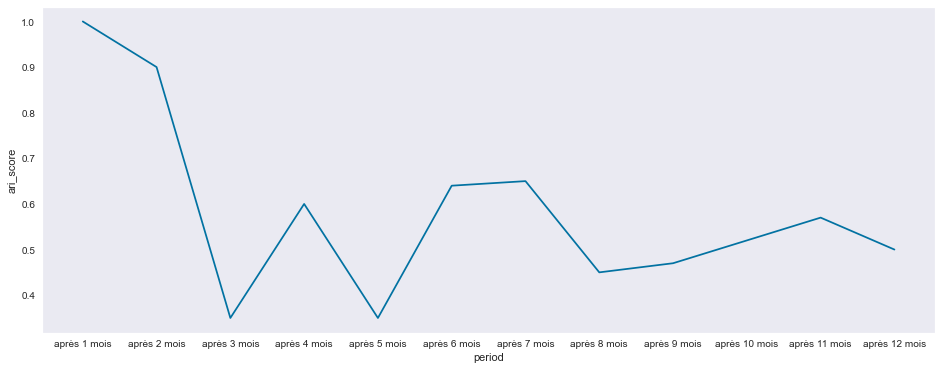

In [570]:
fig = plt.figure(figsize=(16, 6))

bp = sns.lineplot(
    y='ari_score',
    x='period',
    data=pd.DataFrame(
    df_scores,
    columns=['period', 'ari_score'],
),
    #saturation=0.9,
    # order=order,
    # color='darkred',
    ci=None)

for p in bp.patches:
    bp.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points')
plt.show()

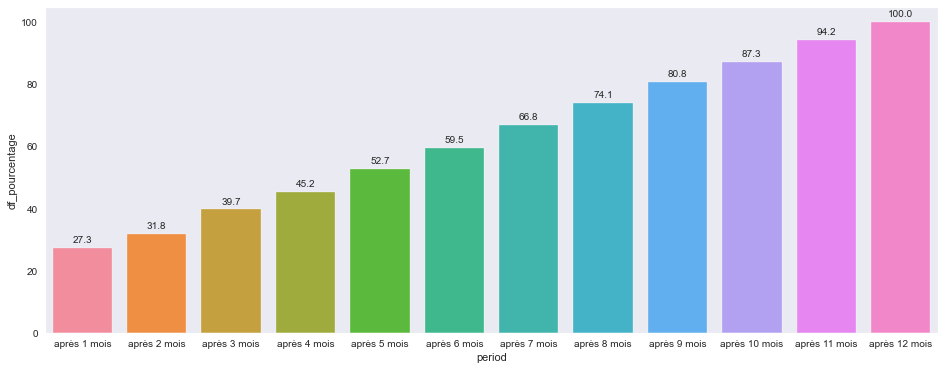

In [579]:
# Evaluation de nombre d'achat au fils du temps

fig = plt.figure(figsize=(16, 6))

bp = sns.barplot(
    y='df_pourcentage',
    x='period',
    data=pd.DataFrame(
    df_scores,
    columns=['period', 'df_pourcentage'],
),
    saturation=0.9,
    # order=order,
    # color='darkred',
    ci=None)

for p in bp.patches:
    bp.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points')
plt.show()